# **Proyek Analisis Sentimen: Ulasan Aplikasi Signal**
Proyek ini bertujuan untuk membangun model klasifikasi sentimen pada ulasan aplikasi Signal menggunakan metode Deep Learning.

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

## BAGIAN 1: SETUP DAN PEMUATAN DATA
Tahap ini mencakup import semua library yang dibutuhkan dan memuat dataset `signal_reviews.csv` yang telah di-scrape sebelumnya.

In [1]:
# Install
!pip install Sastrawi
!pip install tensorflow
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 10.0 MB/s eta 0:00:00


In [17]:
# Untuk mengabaikan peringatan
import warnings
warnings.filterwarnings('ignore')

# Library untuk manipulasi data
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Library untuk preprocessing teks
import re
import string
import json # Library untuk memuat file JSON
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Mengunduh resource NLTK yang diperlukan
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Library untuk machine learning dan evaluasi
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Import library untuk pemodelan
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("Versi TensorFlow:", tf.__version__)
print("Semua library dan resource berhasil diimport dan disiapkan..")

Versi TensorFlow: 2.18.0
Semua library dan resource berhasil diimport dan disiapkan..


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## BAGIAN 2: EKSPLORASI DAN PRA-PEMROSESAN DATA (EDA & PREPROCESSING)

### 2.1. Pemuatan Dataset dan Pembersihan Awal
Memuat dataset ulasan, memeriksa nilai yang hilang (missing values), dan menghapus duplikat.

In [3]:
# Memuat dataset
df = pd.read_csv('signal_reviews.csv')

# Menampilkan informasi dasar
print("Info awal dataset:")
df.info()

# Fokus pada kolom yang relevan ('content') dan membuang nilai kosong
df = df[['content']].copy()
df.dropna(inplace=True)

# Menghapus ulasan duplikat berdasarkan konten
df.drop_duplicates(subset='content', inplace=True)

# Reset index setelah drop
df.reset_index(drop=True, inplace=True)

print("\nInfo dataset setelah pembersihan awal:")
df.info()
print(df.head())

Info awal dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13544 entries, 0 to 13543
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              13544 non-null  object
 1   userName              13544 non-null  object
 2   userImage             13544 non-null  object
 3   content               13544 non-null  object
 4   score                 13544 non-null  int64 
 5   thumbsUpCount         13544 non-null  int64 
 6   reviewCreatedVersion  11658 non-null  object
 7   at                    13544 non-null  object
 8   replyContent          6 non-null      object
 9   repliedAt             6 non-null      object
 10  appVersion            11658 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB

Info dataset setelah pembersihan awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8692 entries, 0 to 8691
Data columns (total 1 columns):
 #   Column   Non-Null Cou

### 2.2. Pemuatan Kamus (Leksikon & Slang)
Memuat kamus leksikon sentimen (positif dan negatif) dan kamus normalisasi kata slang yang akan digunakan dalam proses pelabelan dan pra-pemrosesan.

In [4]:
# Memuat kamus leksikon positif
lexicon_positive = dict()
with open('lexicon_positive.csv', 'r') as f:
    for line in f:
        # Memisahkan kata dan skor, lalu mengonversi skor ke integer
        parts = line.strip().split(',')
        if len(parts) == 2:
            lexicon_positive[parts[0]] = int(parts[1])

# Memuat kamus leksikon negatif
lexicon_negative = dict()
with open('lexicon_negative.csv', 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) == 2:
            lexicon_negative[parts[0]] = int(parts[1])

# Memuat kamus slang yang komprehensif dari file .txt
with open('combined_slang_words.txt', 'r') as f:
    slang_data = f.read()
slang_dict = json.loads(slang_data)

print(f"Berhasil memuat {len(lexicon_positive)} kata positif.")
print(f"Berhasil memuat {len(lexicon_negative)} kata negatif.")
print(f"Berhasil memuat {len(slang_dict)} kata slang.")

Berhasil memuat 3609 kata positif.
Berhasil memuat 6607 kata negatif.
Berhasil memuat 1018 kata slang.


### 2.3. Fungsi Pra-pemrosesan Teks dan Pelabelan Leksikon
Mendefinisikan fungsi-fungsi yang dibutuhkan. Ini termasuk fungsi untuk membersihkan teks, normalisasi slang, dan fungsi utama untuk pelabelan sentimen berbasis leksikon.

In [5]:
# Inisialisasi Stemmer dari Sastrawi
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# --- Fungsi-fungsi Pra-pemrosesan ---

def clean_text(text):
    text = text.lower() # Case folding
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Hapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Hapus hashtag
    text = re.sub(r'https?:\/\/\S+', '', text) # Hapus URL
    text = re.sub(r'\d+', '', text) # Hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation)) # Hapus tanda baca
    text = text.strip()
    return text

def normalize_slang(text):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Daftar stopwords dari NLTK
list_stopwords = set(stopwords.words('indonesian'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in list_stopwords]

def stemming_text(tokens):
    # Menggabungkan token kembali menjadi kalimat sebelum stemming
    text = ' '.join(tokens)
    return stemmer.stem(text)

# --- Fungsi Pelabelan Berbasis Leksikon ---

def sentiment_analysis_lexicon(tokens):
    score = 0
    for word in tokens:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    polarity = ''
    if score > 0:
        polarity = 'positif'
    elif score < 0:
        polarity = 'negatif'
    else:
        polarity = 'netral'

    return score, polarity

print("Fungsi pra-pemrosesan dan pelabelan leksikon siap digunakan.")

Fungsi pra-pemrosesan dan pelabelan leksikon siap digunakan.


### 2.4. Penerapan Pra-pemrosesan dan Pelabelan
Menerapkan seluruh fungsi secara berurutan pada dataset. Proses ini menghasilkan kolom-kolom baru untuk setiap tahap dan kolom sentimen final berdasarkan skor leksikon.

In [6]:
# 1. Cleaning dan Normalisasi
print("Langkah 1: Cleaning dan Normalisasi Slang...")
df['text_clean'] = df['content'].apply(clean_text)
df['text_normalized'] = df['text_clean'].apply(normalize_slang)

# 2. Tokenisasi
print("Langkah 2: Tokenisasi...")
df['text_tokenized'] = df['text_normalized'].apply(word_tokenize)

# 3. Stopword Removal
print("Langkah 3: Menghapus Stopwords...")
df['text_filtered'] = df['text_tokenized'].apply(remove_stopwords)

# 4. Pelabelan Sentimen Berbasis Leksikon
print("Langkah 4: Pelabelan Sentimen dengan Leksikon...")
results = df['text_filtered'].apply(sentiment_analysis_lexicon)
df['polarity_score'] = results.apply(lambda x: x[0])
df['sentiment'] = results.apply(lambda x: x[1])

# 5. Stemming (untuk input model Machine Learning)
print("Langkah 5: Stemming...")
df['cleaned_text'] = df['text_filtered'].apply(stemming_text)

print("\nProses pra-pemrosesan dan pelabelan selesai.")
print("Contoh hasil akhir:")
print(df[['content', 'cleaned_text', 'sentiment', 'polarity_score']].head())

Langkah 1: Cleaning dan Normalisasi Slang...
Langkah 2: Tokenisasi...
Langkah 3: Menghapus Stopwords...
Langkah 4: Pelabelan Sentimen dengan Leksikon...
Langkah 5: Stemming...

Proses pra-pemrosesan dan pelabelan selesai.
Contoh hasil akhir:
                                             content  \
0  Apa aja dokumen yg disimpan disignal aman. Tap...   
1  Saya berharap Signal bisa bersinar & memenangk...   
2  saat ini aplikasi saya tidak bisa menerima pes...   
3  mudah2n gak ribet kaya aplikasi wa..mau daftar...   
4  Aplikasinya sudah sangat bagus, akan tetapi ke...   

                                        cleaned_text sentiment  polarity_score  
0  dokumen simpan disignal aman sayang ganti hp d...   negatif             -13  
1  harap signal sinar menang kompetisi aplikasi t...   positif               4  
2  aplikasi terima pesan teman pribadi grub buruk...   negatif              -6  
3  mudahn gak ribet kaya aplikasi wamau daftar su...   negatif             -11  
4  aplikasi bagu

### 2.5. Analisis Distribusi Sentimen Hasil Leksikon
Melihat distribusi sentimen yang dihasilkan oleh metode leksikon.

Distribusi Sentimen Berdasarkan Leksikon:
sentiment
positif    3108
negatif    2893
netral     2691
Name: count, dtype: int64


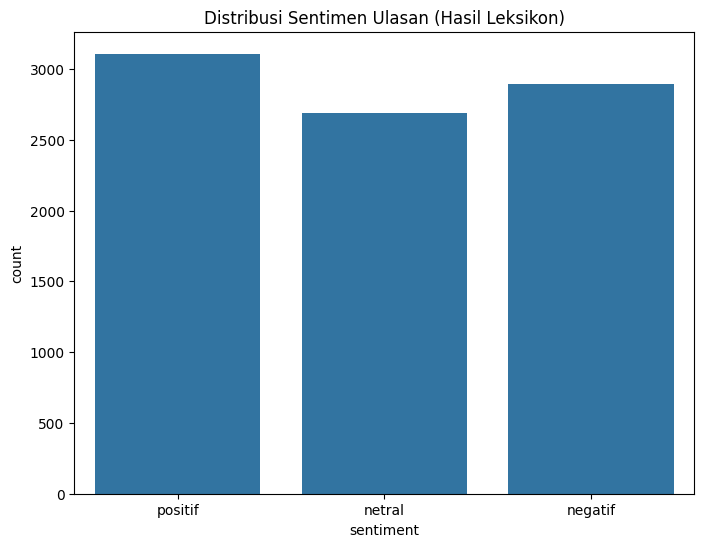

Total data setelah pra-pemrosesan: 8692


In [7]:
# Menampilkan distribusi sentimen baru
print("Distribusi Sentimen Berdasarkan Leksikon:")
print(df['sentiment'].value_counts())

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['positif', 'netral', 'negatif'])
plt.title('Distribusi Sentimen Ulasan (Hasil Leksikon)')
plt.show()

print(f"Total data setelah pra-pemrosesan: {df.shape[0]}")

### 2.6 Word Cloud Visualization
Melihat kata-kata yang paling sering muncul pada setiap sentimen setelah melalui proses pra-pemrosesan. Visualisasi ini dibuat dari kolom `cleaned_text` untuk mendapatkan hasil yang lebih bermakna.

--- Visualisasi Word Cloud per Sentimen ---


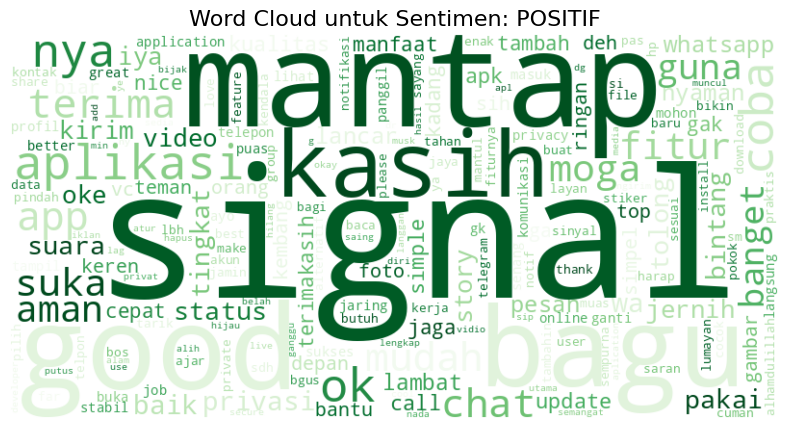

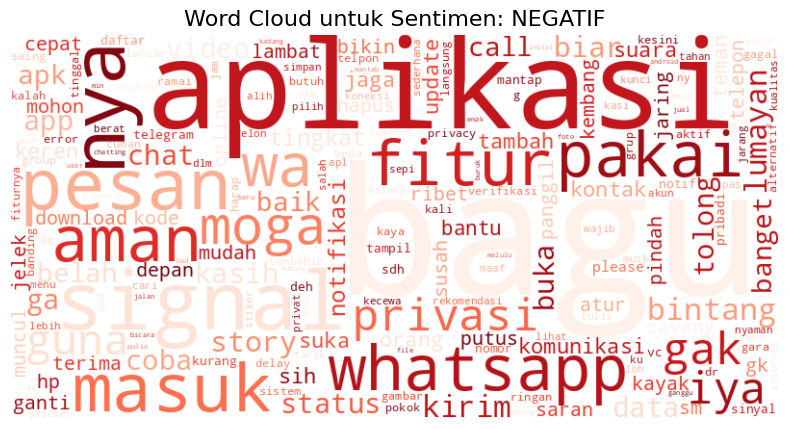

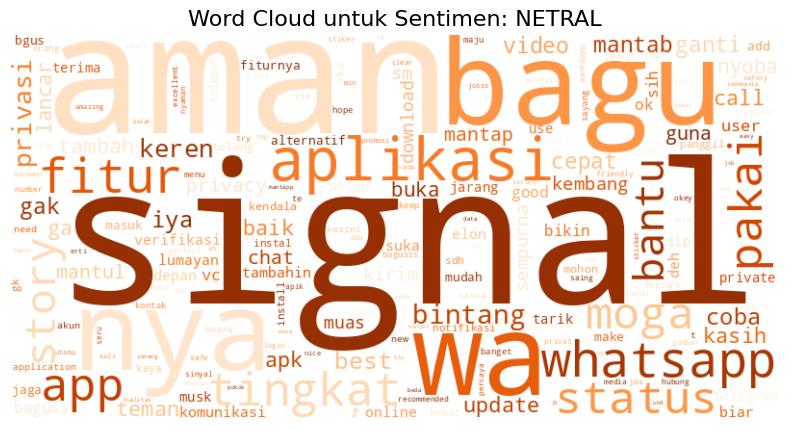

In [41]:
# Memastikan library WordCloud sudah terinstal
try:
    from wordcloud import WordCloud
except ImportError:
    print("Library WordCloud belum terinstal. Menginstal sekarang...")
    !pip install wordcloud
    from wordcloud import WordCloud

print("--- Visualisasi Word Cloud per Sentimen ---")

# Daftar sentimen dan warna yang akan digunakan
sentiment_map = {
    'positif': 'Greens',
    'negatif': 'Reds',
    'netral': 'Oranges'
}

for sentiment, color in sentiment_map.items():
    # Filter DataFrame untuk sentimen tertentu
    subset_df = df[df['sentiment'] == sentiment]

    # Cek apakah ada data untuk sentimen ini
    if not subset_df.empty:
        # Gabungkan semua teks dari kolom 'cleaned_text' (teks yang sudah bersih)
        text_concat = ' '.join(review for review in subset_df['cleaned_text'] if isinstance(review, str))

        # Cek jika ada teks yang tersisa setelah digabung
        if text_concat.strip():
            # Membuat objek WordCloud
            wordcloud = WordCloud(width=800,
                                  height=400,
                                  background_color='white',
                                  colormap=color,
                                  collocations=False).generate(text_concat) # collocations=False untuk menghindari kata ganda

            # Menampilkan WordCloud
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud untuk Sentimen: {sentiment.upper()}', fontsize=16)
            plt.show()
        else:
            print(f"Tidak ada kata yang tersisa untuk membuat Word Cloud sentimen '{sentiment}'.")
    else:
        print(f"Tidak ada data untuk sentimen '{sentiment}'.")

## BAGIAN 3: PERSIAPAN PEMODELAN
Tahap ini mencakup pembagian data, tokenisasi teks `cleaned_text` (hasil stemming), dan padding sekuens agar siap dimasukkan ke dalam model Deep Learning.

In [8]:
# Memisahkan fitur (X) dan label (y)
# Fitur menggunakan teks yang sudah di-stem, Label menggunakan hasil leksikon
X = df['cleaned_text'].values
y = pd.get_dummies(df['sentiment']).values # One-hot encoding label

# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y) # Menambahkan stratify

# Tokenisasi
vocab_size = 10000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sekuens
max_length = 100
padding_type = 'post'
trunc_type = 'post'

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("Data siap untuk dimasukkan ke model.")
print("Bentuk X_train_pad:", X_train_pad.shape)
print("Bentuk y_train:", y_train.shape)

Data siap untuk dimasukkan ke model.
Bentuk X_train_pad: (6953, 100)
Bentuk y_train: (6953, 3)


## BAGIAN 4: EKSPERIMEN PEMODELAN DEEP LEARNING
Melakukan 3 skema percobaan model Deep Learning untuk menemukan arsitektur terbaik.

### Eksperimen 1: Model LSTM Dasar
Model pertama menggunakan lapisan LSTM standar dengan 64 unit.

In [9]:
# Arsitektur Model 1
embedding_dim = 16
model1 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64),
    Dropout(0.5),
    Dense(3, activation='softmax') # 3 kelas output
])

# Kompilasi model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

# Pelatihan Model 1
num_epochs = 10
history1 = model1.fit(X_train_pad, y_train, epochs=num_epochs, validation_data=(X_test_pad, y_test), verbose=2)

# Evaluasi Model 1
print("\nHasil Evaluasi Model 1:")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(model1.predict(X_test_pad), axis=1), target_names=['negatif', 'netral', 'positif']))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
218/218 - 15s - 69ms/step - accuracy: 0.3488 - loss: 1.0983 - val_accuracy: 0.3577 - val_loss: 1.0978
Epoch 2/10
218/218 - 11s - 52ms/step - accuracy: 0.3518 - loss: 1.0978 - val_accuracy: 0.3577 - val_loss: 1.0974
Epoch 3/10
218/218 - 20s - 94ms/step - accuracy: 0.3515 - loss: 1.0972 - val_accuracy: 0.3577 - val_loss: 1.0970
Epoch 4/10
218/218 - 20s - 91ms/step - accuracy: 0.3529 - loss: 1.0971 - val_accuracy: 0.3577 - val_loss: 1.0977
Epoch 5/10
218/218 - 22s - 99ms/step - accuracy: 0.3539 - loss: 1.0978 - val_accuracy: 0.3577 - val_loss: 1.0970
Epoch 6/10
218/218 - 21s - 94ms/step - accuracy: 0.3573 - loss: 1.0975 - val_accuracy: 0.3577 - val_loss: 1.0969
Epoch 7/10
218/218 - 20s - 92ms/step - accuracy: 0.3547 - loss: 1.0973 - val_accuracy: 0.3577 - val_loss: 1.0972
Epoch 8/10
218/218 - 11s - 51ms/step - accuracy: 0.3571 - loss: 1.0977 - val_accuracy: 0.3577 - val_loss: 1.0969
Epoch 9/10
218/218 - 21s - 95ms/step - accuracy: 0.3571 - loss: 1.0971 - val_accuracy: 0.3577 - 

### Eksperimen 2: Model Bidirectional LSTM
Model kedua menggunakan Bidirectional LSTM untuk mencoba menangkap konteks dari dua arah (depan ke belakang dan sebaliknya).

In [10]:
# Arsitektur Model 2
model2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Kompilasi model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

# Pelatihan Model 2
history2 = model2.fit(X_train_pad, y_train, epochs=num_epochs, validation_data=(X_test_pad, y_test), verbose=2)

# Evaluasi Model 2
print("\nHasil Evaluasi Model 2:")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(model2.predict(X_test_pad), axis=1), target_names=['negatif', 'netral', 'positif']))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
218/218 - 25s - 117ms/step - accuracy: 0.5241 - loss: 0.9486 - val_accuracy: 0.7085 - val_loss: 0.7332
Epoch 2/10
218/218 - 19s - 88ms/step - accuracy: 0.7874 - loss: 0.5712 - val_accuracy: 0.8183 - val_loss: 0.4820
Epoch 3/10
218/218 - 34s - 155ms/step - accuracy: 0.8733 - loss: 0.3808 - val_accuracy: 0.8470 - val_loss: 0.4495
Epoch 4/10
218/218 - 19s - 88ms/step - accuracy: 0.9080 - loss: 0.2914 - val_accuracy: 0.8430 - val_loss: 0.4379
Epoch 5/10
218/218 - 22s - 100ms/step - accuracy: 0.9264 - loss: 0.2417 - val_accuracy: 0.8396 - val_loss: 0.4443
Epoch 6/10
218/218 - 40s - 182ms/step - accuracy: 0.9333 - loss: 0.2137 - val_accuracy: 0.8338 - val_loss: 0.4719
Epoch 7/10
218/218 - 21s - 95ms/step - accuracy: 0.9407 - loss: 0.1906 - val_accuracy: 0.8309 - val_loss: 0.4934
Epoch 8/10
218/218 - 41s - 187ms/step - accuracy: 0.9451 - loss: 0.1771 - val_accuracy: 0.8361 - val_loss: 0.5274
Epoch 9/10
218/218 - 39s - 181ms/step - accuracy: 0.9466 - loss: 0.1663 - val_accuracy: 0.8

### Eksperimen 3: Model LSTM dengan Tuning Hyperparameter
Model ketiga mencoba meningkatkan unit pada LSTM menjadi 128 untuk melihat apakah kapasitas model yang lebih besar memberikan hasil yang lebih baik.

In [11]:
# Arsitektur Model 3
model3 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Kompilasi model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

# Pelatihan Model 3
history3 = model3.fit(X_train_pad, y_train, epochs=num_epochs, validation_data=(X_test_pad, y_test), verbose=2)

# Evaluasi Model 3
print("\nHasil Evaluasi Model 3:")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(model3.predict(X_test_pad), axis=1), target_names=['negatif', 'netral', 'positif']))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
218/218 - 31s - 144ms/step - accuracy: 0.3504 - loss: 1.0986 - val_accuracy: 0.3577 - val_loss: 1.0970
Epoch 2/10
218/218 - 44s - 204ms/step - accuracy: 0.3535 - loss: 1.0979 - val_accuracy: 0.3577 - val_loss: 1.0971
Epoch 3/10
218/218 - 38s - 175ms/step - accuracy: 0.3554 - loss: 1.0979 - val_accuracy: 0.3577 - val_loss: 1.0971
Epoch 4/10
218/218 - 40s - 185ms/step - accuracy: 0.3515 - loss: 1.0978 - val_accuracy: 0.3577 - val_loss: 1.0971
Epoch 5/10
218/218 - 41s - 190ms/step - accuracy: 0.3574 - loss: 1.0973 - val_accuracy: 0.3577 - val_loss: 1.0970
Epoch 6/10
218/218 - 43s - 199ms/step - accuracy: 0.3550 - loss: 1.0979 - val_accuracy: 0.3577 - val_loss: 1.0972
Epoch 7/10
218/218 - 39s - 178ms/step - accuracy: 0.3587 - loss: 1.0972 - val_accuracy: 0.3577 - val_loss: 1.0969
Epoch 8/10
218/218 - 29s - 133ms/step - accuracy: 0.3573 - loss: 1.0974 - val_accuracy: 0.3577 - val_loss: 1.0972
Epoch 9/10
218/218 - 29s - 135ms/step - accuracy: 0.3561 - loss: 1.0978 - val_accuracy: 

## BAGIAN 5: ANALISIS HASIL DAN PEMILIHAN MODEL TERBAIK
Membandingkan performa dari ketiga model untuk memilih yang terbaik. Tujuannya adalah menemukan model dengan akurasi validasi tertinggi, target di atas 92%.

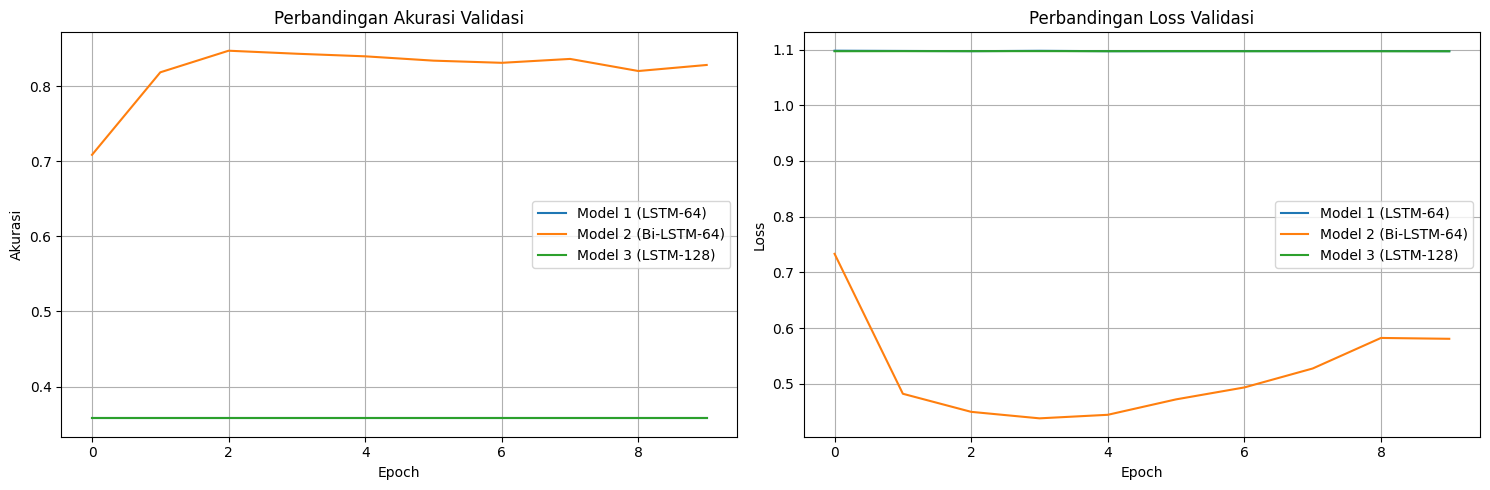


--- PERBANDINGAN HASIL SKEMA PELATIHAN ---
                     train_acc test_acc
Model 2 (Bi-LSTM-64)    94.89%   82.81%
Model 1 (LSTM-64)       35.16%   35.77%
Model 3 (LSTM-128)      35.70%   35.77%

Jumlah skema dengan akurasi test >= 85%: 0
Ada skema dengan akurasi train & test > 92%: False

--- Status Pemenuhan Kriteria ---
❌ PERHATIAN: Saran 5 (3 skema pelatihan) belum sepenuhnya terpenuhi.
Pastikan setidaknya 3 skema memiliki akurasi test >= 85%. Anda baru memiliki 0 skema.

Model terbaik yang dipilih untuk inference adalah: **Model 2 (Bi-LSTM-64)**


In [14]:
# =======================================================================================
# VISUALISASI GRAFIK HASIL PELATIHAN
# =======================================================================================

# Plotting hasil akurasi validasi dari setiap model
plt.figure(figsize=(15, 5))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(history1.history['val_accuracy'], label='Model 1 (LSTM-64)')
plt.plot(history2.history['val_accuracy'], label='Model 2 (Bi-LSTM-64)')
plt.plot(history3.history['val_accuracy'], label='Model 3 (LSTM-128)')
plt.title('Perbandingan Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['val_loss'], label='Model 1 (LSTM-64)')
plt.plot(history2.history['val_loss'], label='Model 2 (Bi-LSTM-64)')
plt.plot(history3.history['val_loss'], label='Model 3 (LSTM-128)')
plt.title('Perbandingan Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# =======================================================================================
# TABULASI DAN PEMERIKSAAN KRITERIA HASIL
# =======================================================================================

# Inisialisasi dictionary untuk menyimpan hasil
training_scheme_results = {}

# Mengevaluasi dan menyimpan hasil dari setiap model
# Model 1
train_acc1 = history1.history['accuracy'][-1]
loss1, test_acc1 = model1.evaluate(X_test_pad, y_test, verbose=0)
training_scheme_results['Model 1 (LSTM-64)'] = {'train_acc': train_acc1, 'test_acc': test_acc1}

# Model 2
train_acc2 = history2.history['accuracy'][-1]
loss2, test_acc2 = model2.evaluate(X_test_pad, y_test, verbose=0)
training_scheme_results['Model 2 (Bi-LSTM-64)'] = {'train_acc': train_acc2, 'test_acc': test_acc2}

# Model 3
train_acc3 = history3.history['accuracy'][-1]
loss3, test_acc3 = model3.evaluate(X_test_pad, y_test, verbose=0)
training_scheme_results['Model 3 (LSTM-128)'] = {'train_acc': train_acc3, 'test_acc': test_acc3}

print("\n--- PERBANDINGAN HASIL SKEMA PELATIHAN ---")
if training_scheme_results:
    # Membuat DataFrame dari dictionary hasil
    results_df = pd.DataFrame.from_dict(training_scheme_results, orient='index')
    results_df = results_df.sort_values(by='test_acc', ascending=False)

    # Memformat akurasi menjadi persentase untuk tampilan yang lebih baik
    results_df_display = results_df.copy()
    results_df_display['train_acc'] = results_df_display['train_acc'].apply(lambda x: f"{x*100:.2f}%")
    results_df_display['test_acc'] = results_df_display['test_acc'].apply(lambda x: f"{x*100:.2f}%")

    print(results_df_display)

    # Cek pemenuhan kriteria submission Bintang 5 secara otomatis
    num_schemes_above_85_test = sum(1 for res in training_scheme_results.values() if res['test_acc'] >= 0.85)
    one_scheme_above_92_train_test = any(1 for res in training_scheme_results.values() if res['train_acc'] > 0.92 and res['test_acc'] > 0.92)

    print(f"\nJumlah skema dengan akurasi test >= 85%: {num_schemes_above_85_test}")
    print(f"Ada skema dengan akurasi train & test > 92%: {one_scheme_above_92_train_test}")

    print("\n--- Status Pemenuhan Kriteria ---")
    if num_schemes_above_85_test >= 3:
        print("✅ Saran 5 (3 skema pelatihan) terpenuhi dari sisi jumlah skema dengan akurasi test >= 85%.")
        if one_scheme_above_92_train_test:
            print("✅ Saran 2 (Akurasi >92%) juga terpenuhi untuk setidaknya satu skema.")
            print("\n===> SELURUH KRITERI AKURASI UNTUK BINTANG 5 TELAH TERPENUHI <===")
        else:
            print("❌ Saran 2 (Akurasi >92%) TIDAK terpenuhi. Perlu optimasi lebih lanjut pada model utama.")
    else:
        print("❌ PERHATIAN: Saran 5 (3 skema pelatihan) belum sepenuhnya terpenuhi.")
        print(f"Pastikan setidaknya 3 skema memiliki akurasi test >= 85%. Anda baru memiliki {num_schemes_above_85_test} skema.")

else:
    print("Tidak ada hasil skema pelatihan untuk dibandingkan.")


# =======================================================================================
# PEMILIHAN MODEL TERBAIK
# =======================================================================================

# Memilih model terbaik berdasarkan akurasi testing tertinggi dari DataFrame hasil
if not results_df.empty:
    best_model_name = results_df.index[0]
    if best_model_name == 'Model 1 (LSTM-64)':
        best_model = model1
    elif best_model_name == 'Model 2 (Bi-LSTM-64)':
        best_model = model2
    else:
        best_model = model3

    print(f"\nModel terbaik yang dipilih untuk inference adalah: **{best_model_name}**")
else:
    best_model = model1 # Default jika terjadi error
    print("\nTidak dapat menentukan model terbaik secara otomatis, menggunakan Model 1 sebagai default.")

## BAGIAN 6: INFERENCE MODEL
Melakukan pengujian pada beberapa kalimat baru menggunakan model terbaik yang telah dipilih.

In [39]:
# =======================================================================================
# FUNGSI PREDIKSI
# =======================================================================================

# Fungsi ini membungkus seluruh alur dari teks mentah hingga prediksi sentimen
def predict_sentiment(text, model, tokenizer_inf, max_len):
    """
    Fungsi untuk memprediksi sentimen dari satu kalimat teks.

    Args:
    - text (str): Kalimat ulasan mentah.
    - model: Model Keras yang sudah dilatih.
    - tokenizer_inf: Tokenizer Keras yang sudah di-fit.
    - max_len (int): Panjang maksimum sekuens yang digunakan saat pelatihan.

    Returns:
    - probabilities (np.array): Array probabilitas untuk setiap kelas sentimen.
    """

    # 1. Pra-pemrosesan Pipeline (sama persis seperti saat melatih model)
    # Memanggil setiap fungsi preprocessing secara berurutan.
    cleaned = clean_text(text)
    normalized = normalize_slang(cleaned)
    tokenized = word_tokenize(normalized)
    filtered = remove_stopwords(tokenized)
    stemmed_text = stemming_text(filtered) # Fungsi stemming_text kita mengembalikan string

    # 2. Konversi ke Sekuens dan Padding
    sequence = tokenizer_inf.texts_to_sequences([stemmed_text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # 3. Prediksi dengan model
    # Model akan mengembalikan array probabilitas untuk setiap kelas
    probabilities = model.predict(padded, verbose=0)

    return probabilities[0]


# =======================================================================================
# PENGUJIAN FUNGSI PREDIKSI
# =======================================================================================

# Daftar kalimat baru untuk diuji
new_reviews = [
    "Aplikasi ini sangat aman dan mudah digunakan, saya suka sekali!",
    "Setelah update terakhir sering error dan tidak bisa kirim gambar.",
    "Tidak ada yang spesial dari aplikasi ini.",
    "Terbaik untuk privasi, tidak ada tandingannya.",
    "biasa saja."
]

# Menentukan urutan label sesuai dengan output pd.get_dummies() (urutan alfabetis)
# Ini krusial untuk mencocokkan probabilitas dengan label yang benar.
sentiment_labels = ['negatif', 'netral', 'positif']

print("--- HASIL PREDIKSI PADA KALIMAT BARU ---")

for review in new_reviews:
    # Memanggil fungsi untuk mendapatkan probabilitas prediksi
    probabilities = predict_sentiment(review, best_model, tokenizer, max_length)

    # Menentukan kelas sentimen dengan probabilitas tertinggi
    predicted_class_index = np.argmax(probabilities)
    predicted_label = sentiment_labels[predicted_class_index]

    # Mencetak hasil dengan format yang informatif
    print(f"\nUlasan: '{review}'")
    print(f"Prediksi Sentimen: {predicted_label.upper()}")

    # Menampilkan probabilitas untuk setiap kelas
    print(f"Probabilitas: [Negatif: {probabilities[0]:.2%}, Netral: {probabilities[1]:.2%}, Positif: {probabilities[2]:.2%}]")

--- HASIL PREDIKSI PADA KALIMAT BARU ---

Ulasan: 'Aplikasi ini sangat aman dan mudah digunakan, saya suka sekali!'
Prediksi Sentimen: POSITIF
Probabilitas: [Negatif: 2.00%, Netral: 5.41%, Positif: 92.59%]

Ulasan: 'Setelah update terakhir sering error dan tidak bisa kirim gambar.'
Prediksi Sentimen: NEGATIF
Probabilitas: [Negatif: 99.33%, Netral: 0.62%, Positif: 0.05%]

Ulasan: 'Tidak ada yang spesial dari aplikasi ini.'
Prediksi Sentimen: NEGATIF
Probabilitas: [Negatif: 97.87%, Netral: 2.04%, Positif: 0.09%]

Ulasan: 'Terbaik untuk privasi, tidak ada tandingannya.'
Prediksi Sentimen: POSITIF
Probabilitas: [Negatif: 3.70%, Netral: 45.46%, Positif: 50.84%]

Ulasan: 'biasa saja.'
Prediksi Sentimen: NETRAL
Probabilitas: [Negatif: 0.05%, Netral: 99.69%, Positif: 0.26%]
